In [1]:
#Import libraries and load preprocessed data
import pandas as pd 
import numpy as np 
import pickle
import json
import warnings
warnings.filterwarnings("ignore")

#machine learning libraries
from sklearn.model_selection import train_test_split,cross_val_predict ,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support
)
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Time tracking
import time
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
np.random.seed(42)
print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
try:
    df=pd.read_csv('/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/data/processed/data_training_ready.csv')
    print("✅ Data loaded successfully!")

    print(df.head())
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Data loaded successfully!
  sentiment                                               text
0  Negative  awww thats bummer shoulda got david carr third...
1  Negative  upset cant update facebook texting might cry r...
2  Negative     dived many times ball managed save rest bounds
3  Negative                   whole body feels itchy like fire
4  Negative                              behaving mad cant see


In [5]:
print(f"\n Dataset Info:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")


 Dataset Info:
   Shape: (1466544, 2)
   Columns: ['sentiment', 'text']


In [7]:
# Dataset statistics
print(f"\n Dataset Statistics:")
print(f"   Total samples: {len(df):,}")
print(f"   Unique sentiments: {df['sentiment']. nunique()}")
print(f"\n   Sentiment Distribution:")
sentiment_dist = df['sentiment'].value_counts()
for sentiment, count in sentiment_dist. items():
    pct = count / len(df) * 100
    bar = '▓' * int(pct / 5)
    print(f"   {sentiment:12} : {count:,} ({pct:.2f}%)  {bar}")


 Dataset Statistics:
   Total samples: 1,466,544
   Unique sentiments: 2

   Sentiment Distribution:
   Negative     : 742,908 (50.66%)  ▓▓▓▓▓▓▓▓▓▓
   Positive     : 723,636 (49.34%)  ▓▓▓▓▓▓▓▓▓


In [8]:
# Check for missing values
missing = df. isnull().sum()
if missing.sum() > 0:
    print(f"\n⚠️ WARNING: Missing values detected:")
    print(missing[missing > 0])
    print("   Removing rows with missing values...")
    df = df.dropna()
    print(f"   New shape: {df.shape}")
else:
    print(f"\n✅ No missing values found")


✅ No missing values found


In [3]:
# TRAIN-VALIDATION-TEST SPLIT
#Split data into training, validation, and test sets
X = df['text']
y = df['sentiment']
# First split:  85% temp (train+val), 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y  # Maintain class distribution
)
# Second split: 70% train, 15% val (from the 85% temp)
# 0.176 * 0.85 ≈ 0.15 of total
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
)
print(f"\n Split Complete!")
print(f"\n Dataset Sizes:")
print(f"   Training set:    {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test set:        {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")


 Split Complete!

 Dataset Sizes:
   Training set:    1,027,167 samples (70.0%)
   Validation set: 219,395 samples (15.0%)
   Test set:        219,982 samples (15.0%)



 Class Distribution Verification:

   Training Set:
      Negative     : 520,333 (50.66%)
      Positive     : 506,834 (49.34%)

   Validation Set:
      Negative     : 111,139 (50.66%)
      Positive     : 108,256 (49.34%)

   Test Set:
      Negative     :  111,436 (50.66%)
      Positive     :  108,546 (49.34%)


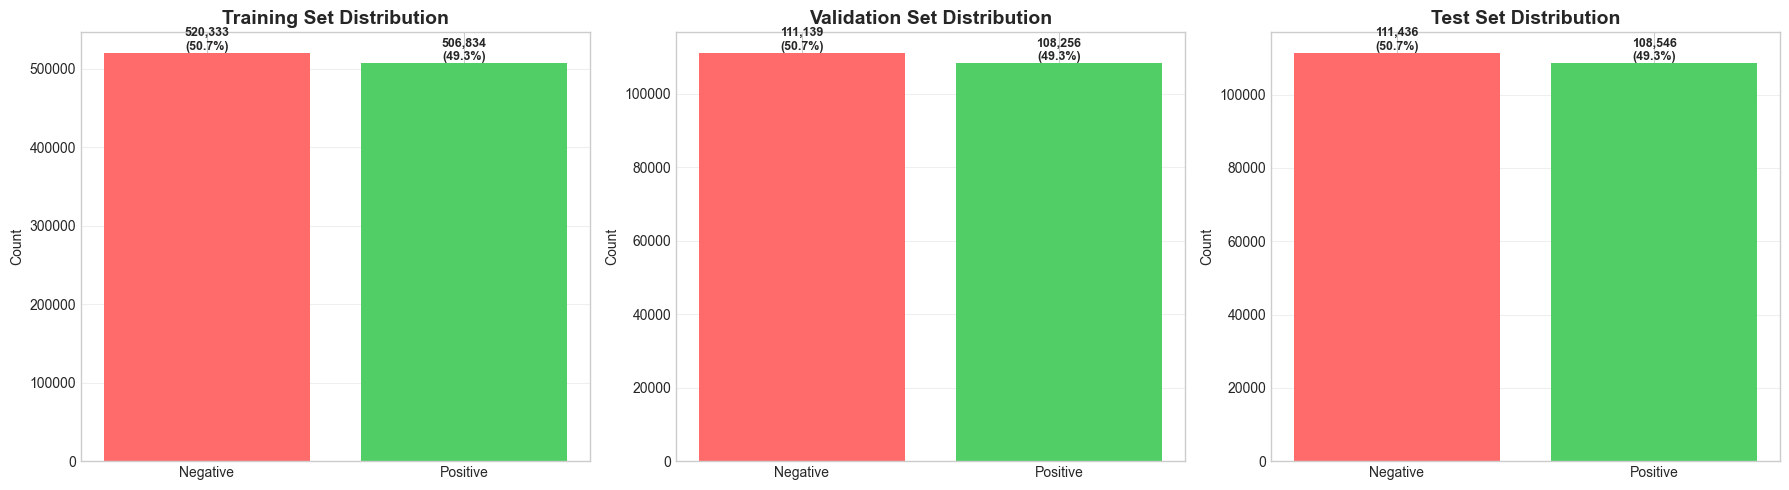


✅ Saved:  data_split_distribution.png


In [4]:
# Verify class distribution in each set
print(f"\n Class Distribution Verification:")

print(f"\n   Training Set:")
train_dist = y_train.value_counts()
for sentiment, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"      {sentiment:12} : {count:,} ({pct:.2f}%)")

print(f"\n   Validation Set:")
val_dist = y_val.value_counts()
for sentiment, count in val_dist.items():
    pct = count / len(y_val) * 100
    print(f"      {sentiment:12} : {count:,} ({pct:.2f}%)")

print(f"\n   Test Set:")
test_dist = y_test.value_counts()
for sentiment, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"      {sentiment:12} :  {count:,} ({pct:.2f}%)")

# Visualize split
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_sentiment = {'Positive': '#51cf66', 'Negative': '#ff6b6b', 'Neutral': '#ffd43b'}

for idx, (dataset_name, dataset) in enumerate([
    ('Training', y_train), 
    ('Validation', y_val), 
    ('Test', y_test)
]):
    counts = dataset.value_counts()
    colors = [colors_sentiment. get(s, '#999') for s in counts.index]
    
    axes[idx].bar(range(len(counts)), counts.values, color=colors)
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=0)
    axes[idx].set_title(f'{dataset_name} Set Distribution', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (sentiment, count) in enumerate(counts.items()):
        axes[idx].text(i, count, f'{count:,}\n({count/len(dataset)*100:.1f}%)', 
                      ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved:  data_split_distribution.png")

TF-IDF Vectorization

In [5]:
#Convert text to numerical features using TF-IDF
tfidf_config={
    'max_features': 5000, # Top 5000 most important words
    'ngram_range': (1, 2), # Unigrams and bigrams
    'min_df': 2,                 # Word must appear in at least 2 documents
    'max_df': 0.8,               # Word must appear in less than 80% of documents
    'sublinear_tf': True,        # Use logarithmic term frequency
    'strip_accents': 'unicode',  # Remove accents
    'analyzer': 'word',          # Analyze by word
    'token_pattern': r'\w{3,}',  # Words with at least 3 characters
    'stop_words': None           # Already removed in preprocessing
}

In [6]:
# Initialize TF-IDF Vectorizer
print(f"\n Initializing TF-IDF Vectorizer...")
tfidf_vectorizer = TfidfVectorizer(**tfidf_config)

# Fit on training data only (important!)
print(f" Fitting TF-IDF on training data...")
start_time = time.time()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

fit_time = time.time() - start_time
print(f"   ✅ Fitting complete in {fit_time:.2f} seconds")
# Transform validation and test sets
print(f"\n Transforming validation and test sets...")
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"✅ Vectorization complete!")


 Initializing TF-IDF Vectorizer...
 Fitting TF-IDF on training data...
   ✅ Fitting complete in 33.76 seconds

 Transforming validation and test sets...
✅ Vectorization complete!


In [8]:
# Display statistics
print(f"\n TF-IDF Statistics:")
print(f"   Vocabulary size: {len(tfidf_vectorizer.vocabulary_):,} unique terms")
print(f"   Feature names (first 20): {list(tfidf_vectorizer. get_feature_names_out()[:20])}")


 TF-IDF Statistics:
   Vocabulary size: 5,000 unique terms
   Feature names (first 20): ['aaah', 'aah', 'aaron', 'able', 'able get', 'able make', 'able see', 'absolutely', 'abt', 'accent', 'accept', 'accepted', 'access', 'accident', 'accidentally', 'accomplished', 'according', 'account', 'accounts', 'ace']


In [9]:
print(f"\n Matrix Shapes:")
print(f"   Training:    {X_train_tfidf.shape} ({X_train_tfidf. shape[0]: ,} samples × {X_train_tfidf.shape[1]:,} features)")
print(f"   Validation: {X_val_tfidf.shape} ({X_val_tfidf.shape[0]:,} samples × {X_val_tfidf.shape[1]:,} features)")
print(f"   Test:       {X_test_tfidf.shape} ({X_test_tfidf.shape[0]: ,} samples × {X_test_tfidf.shape[1]:,} features)")



 Matrix Shapes:
   Training:    (1027167, 5000) ( 1,027,167 samples × 5,000 features)
   Validation: (219395, 5000) (219,395 samples × 5,000 features)
   Test:       (219982, 5000) ( 219,982 samples × 5,000 features)


In [10]:
# Calculate sparsity
sparsity = (1.0 - X_train_tfidf. nnz / (X_train_tfidf. shape[0] * X_train_tfidf.shape[1])) * 100
print(f"\n Matrix Sparsity:  {sparsity:.2f}%")
print(f"   (Most values are zero - efficient storage)")


 Matrix Sparsity:  99.88%
   (Most values are zero - efficient storage)



 Top 20 Features by Average TF-IDF Score:
    1. good                 :  0.0128
    2. day                  :  0.0122
    3. like                 :  0.0117
    4. get                  :  0.0115
    5. love                 :  0.0112
    6. today                :  0.0106
    7. going                :  0.0106
    8. dont                 :  0.0103
    9. work                 :  0.0101
   10. got                  :  0.0100
   11. lol                  :  0.0098
   12. cant                 :  0.0098
   13. back                 :  0.0093
   14. time                 :  0.0093
   15. one                  :  0.0087
   16. know                 :  0.0085
   17. really               :  0.0081
   18. want                 :  0.0078
   19. see                  :  0.0077
   20. well                 :  0.0077


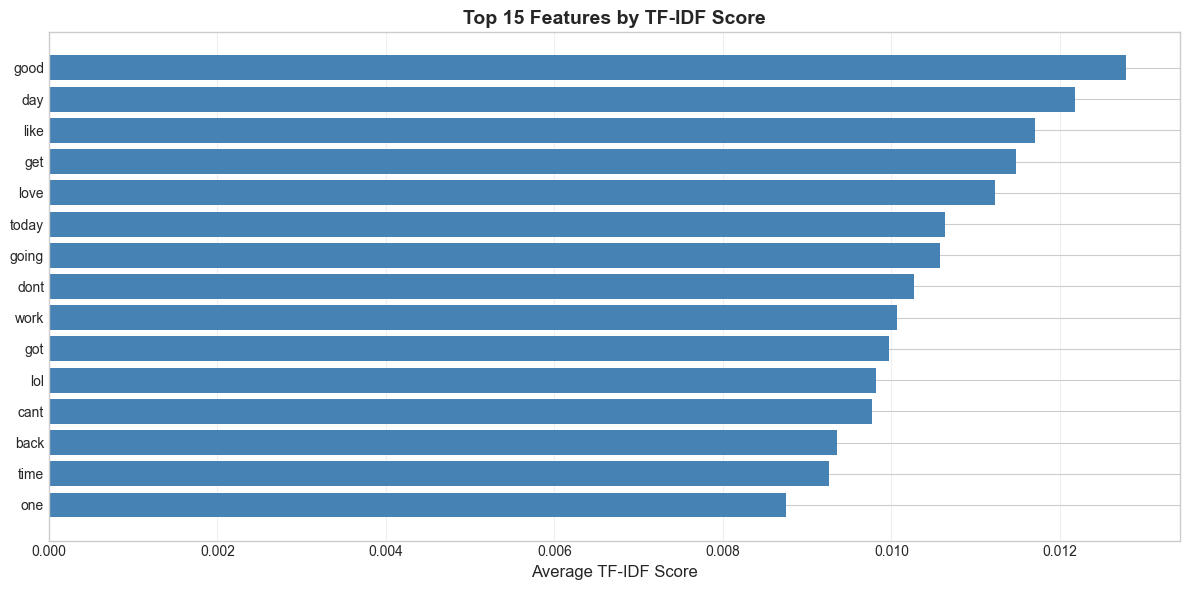


✅ Saved: top_tfidf_features.png


In [12]:
# Show top features by TF-IDF score
print(f"\n Top 20 Features by Average TF-IDF Score:")
feature_names = tfidf_vectorizer. get_feature_names_out()
tfidf_scores = X_train_tfidf.mean(axis=0).A1  # Average TF-IDF score per feature
top_indices = tfidf_scores.argsort()[-20:][::-1]

for i, idx in enumerate(top_indices, 1):
    print(f"   {i:2}. {feature_names[idx]:20} :  {tfidf_scores[idx]:.4f}")

# Visualize top features
plt.figure(figsize=(12, 6))
top_features = [feature_names[idx] for idx in top_indices[: 15]]
top_scores = [tfidf_scores[idx] for idx in top_indices[:15]]

plt. barh(range(len(top_features)), top_scores, color='steelblue')
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Average TF-IDF Score', fontsize=12)
plt.title('Top 15 Features by TF-IDF Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_tfidf_features.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: top_tfidf_features.png")

Model Training

In [13]:
#Train multiple machine learning models
# Dictionary to store all models and results
models_results = {}

print(f"\n Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    C=1.0,                  # Regularization strength
    solver='lbfgs',         # Optimization algorithm
    class_weight='balanced' # Handle class imbalance
)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time
print(f"✅ Training complete in {train_time:.2f} seconds")


 Training Logistic Regression...
✅ Training complete in 7.21 seconds


In [15]:
# Validation predictions
print(f" Making validation predictions...")
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_val_proba_lr = lr_model.predict_proba(X_val_tfidf)

 Making validation predictions...


In [16]:
# Calculate metrics
lr_acc = accuracy_score(y_val, y_val_pred_lr)
lr_precision = precision_score(y_val, y_val_pred_lr, average='weighted')
lr_recall = recall_score(y_val, y_val_pred_lr, average='weighted')
lr_f1 = f1_score(y_val, y_val_pred_lr, average='weighted')

In [18]:
print(f"\n Validation Results:")
print(f"   Accuracy:   {lr_acc:.4f} ({lr_acc*100:.2f}%)")
print(f"   Precision: {lr_precision:.4f} ({lr_precision*100:.2f}%)")
print(f"   Recall:    {lr_recall:.4f} ({lr_recall*100:.2f}%)")
print(f"   F1-Score:  {lr_f1:.4f} ({lr_f1*100:.2f}%)")


 Validation Results:
   Accuracy:   0.7714 (77.14%)
   Precision: 0.7725 (77.25%)
   Recall:    0.7714 (77.14%)
   F1-Score:  0.7713 (77.13%)


In [19]:
models_results['Logistic Regression'] = {
    'model': lr_model,
    'train_time': train_time,
    'val_predictions': y_val_pred_lr,
    'val_probabilities': y_val_proba_lr,
    'accuracy': lr_acc,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1':  lr_f1
}

In [22]:
#NAIVE BAYES
print(f"\n Training Naive Bayes...")
start_time = time.time()

nb_model = MultinomialNB(
    alpha=1.0  # Laplace smoothing
)

nb_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

print(f"✅ Training complete in {train_time:.2f} seconds")

# Validation predictions
print(f" Making validation predictions...")
y_val_pred_nb = nb_model.predict(X_val_tfidf)
y_val_proba_nb = nb_model.predict_proba(X_val_tfidf)

# Calculate metrics
nb_acc = accuracy_score(y_val, y_val_pred_nb)
nb_precision = precision_score(y_val, y_val_pred_nb, average='weighted')
nb_recall = recall_score(y_val, y_val_pred_nb, average='weighted')
nb_f1 = f1_score(y_val, y_val_pred_nb, average='weighted')

print(f"\n Validation Results:")
print(f"   Accuracy:  {nb_acc:.4f} ({nb_acc*100:.2f}%)")
print(f"   Precision: {nb_precision:.4f} ({nb_precision*100:.2f}%)")
print(f"   Recall:    {nb_recall:.4f} ({nb_recall*100:.2f}%)")
print(f"   F1-Score:  {nb_f1:.4f} ({nb_f1*100:.2f}%)")

models_results['Naive Bayes'] = {
    'model': nb_model,
    'train_time': train_time,
    'val_predictions': y_val_pred_nb,
    'val_probabilities': y_val_proba_nb,
    'accuracy': nb_acc,
    'precision':  nb_precision,
    'recall': nb_recall,
    'f1': nb_f1
}


 Training Naive Bayes...
✅ Training complete in 3.54 seconds
 Making validation predictions...

 Validation Results:
   Accuracy:  0.7546 (75.46%)
   Precision: 0.7546 (75.46%)
   Recall:    0.7546 (75.46%)
   F1-Score:  0.7545 (75.45%)


In [23]:
#LINEAR SVM
print(f"\n Training Linear SVM...")
start_time = time.time()

svm_model = LinearSVC(
    max_iter=1000,
    random_state=42,
    C=1.0,
    class_weight='balanced',
    dual=False  # Recommended when n_samples > n_features
)

svm_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

print(f"✅ Training complete in {train_time:.2f} seconds")

# Validation predictions
print(f" Making validation predictions...")
y_val_pred_svm = svm_model.predict(X_val_tfidf)

# Calculate metrics
svm_acc = accuracy_score(y_val, y_val_pred_svm)
svm_precision = precision_score(y_val, y_val_pred_svm, average='weighted')
svm_recall = recall_score(y_val, y_val_pred_svm, average='weighted')
svm_f1 = f1_score(y_val, y_val_pred_svm, average='weighted')

print(f"\n Validation Results:")
print(f"   Accuracy:  {svm_acc:.4f} ({svm_acc*100:.2f}%)")
print(f"   Precision: {svm_precision:.4f} ({svm_precision*100:.2f}%)")
print(f"   Recall:    {svm_recall:.4f} ({svm_recall*100:.2f}%)")
print(f"   F1-Score:  {svm_f1:.4f} ({svm_f1*100:.2f}%)")

models_results['Linear SVM'] = {
    'model': svm_model,
    'train_time': train_time,
    'val_predictions': y_val_pred_svm,
    'val_probabilities': None,  # SVM doesn't have predict_proba by default
    'accuracy': svm_acc,
    'precision':  svm_precision,
    'recall': svm_recall,
    'f1': svm_f1
}




 Training Linear SVM...
✅ Training complete in 14.41 seconds
 Making validation predictions...

 Validation Results:
   Accuracy:  0.7709 (77.09%)
   Precision: 0.7724 (77.24%)
   Recall:    0.7709 (77.09%)
   F1-Score:  0.7708 (77.08%)


In [28]:
# Create comparison DataFrame
comparison_data = []
for model_name, results in models_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1'],
        'Training Time (s)': results['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)

# Sort by F1-Score (descending)
comparison_df = comparison_df. sort_values('F1-Score', ascending=False).reset_index(drop=True)

print(f"\n MODEL PERFORMANCE COMPARISON:\n")
display(comparison_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'Training Time (s)': '{:.2f}'
}).background_gradient(subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'], cmap='Greens'))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_f1 = comparison_df.iloc[0]['F1-Score']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   F1-Score: {best_model_f1:.4f} ({best_model_f1*100:.2f}%)")


 MODEL PERFORMANCE COMPARISON:



,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s)
0,Logistic Regression,0.7714,0.7725,0.7714,0.7713,7.21
1,Linear SVM,0.7709,0.7724,0.7709,0.7708,14.41
2,Naive Bayes,0.7546,0.7546,0.7546,0.7545,3.54



 BEST MODEL: Logistic Regression
   F1-Score: 0.7713 (77.13%)


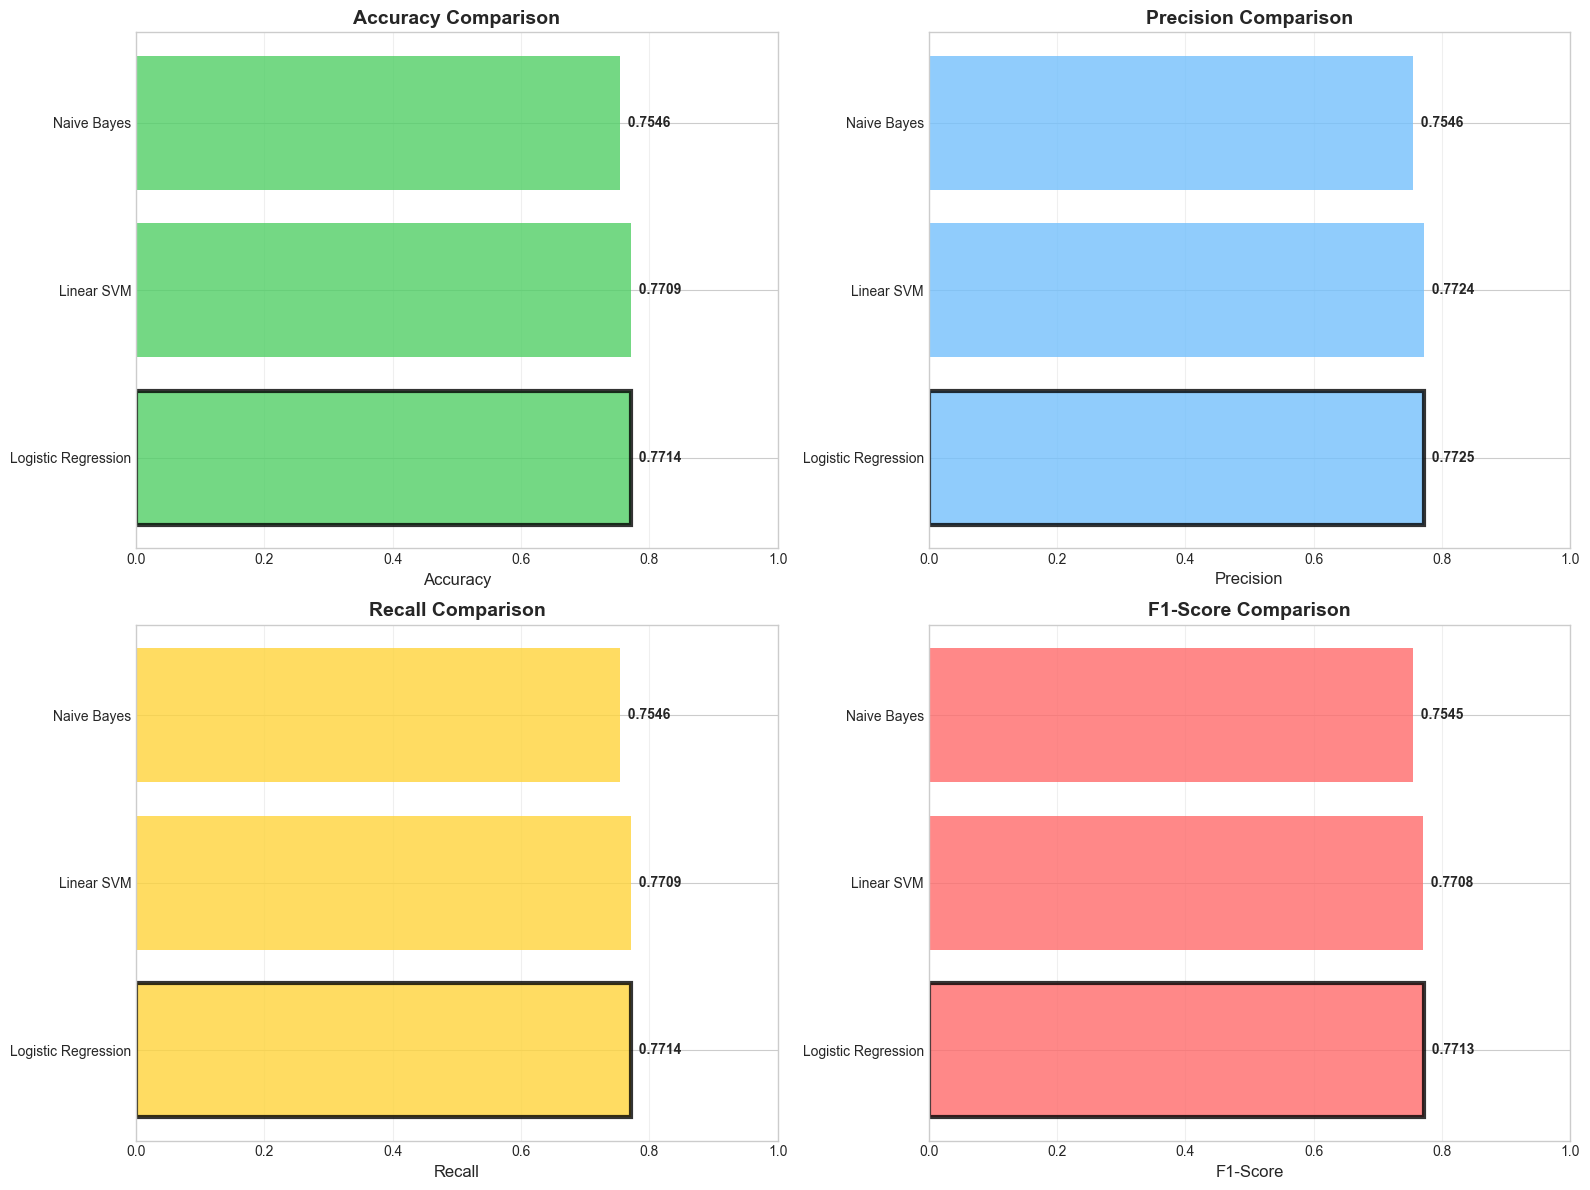


✅ Saved: model_comparison.png


In [29]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#51cf66', '#74c0fc', '#ffd43b', '#ff6b6b']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    values = comparison_df[metric].values
    model_names = comparison_df['Model'].values
    
    bars = ax.barh(range(len(values)), values, color=colors[idx], alpha=0.8)
    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim([0, 1.0])
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, values)):
        ax.text(val, i, f'  {val:.4f}', va='center', fontweight='bold')
    
    # Highlight best
    best_idx = values.argmax()
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: model_comparison.png")


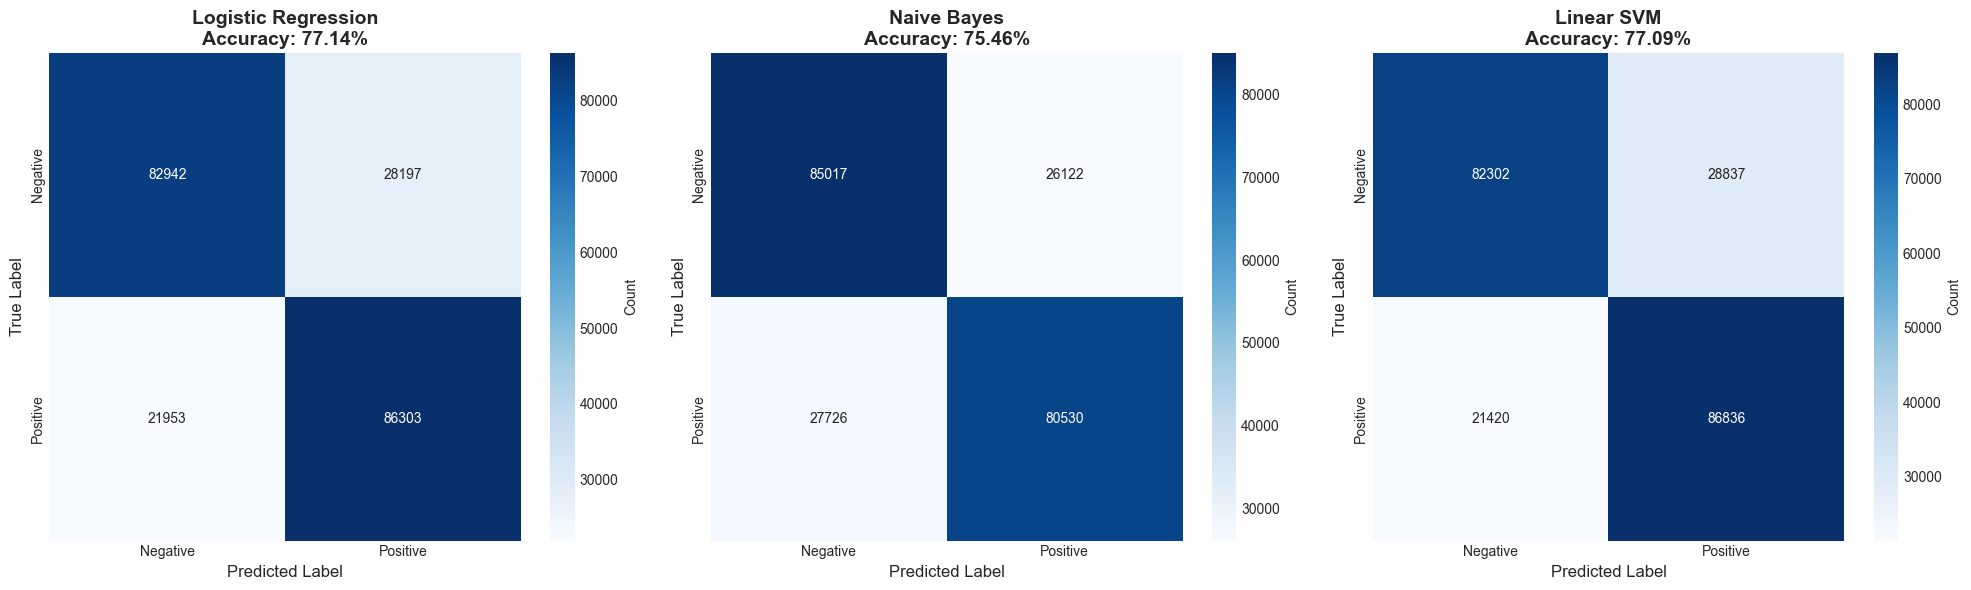

✅ Saved: confusion_matrices_comparison.png


In [30]:
# Visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (model_name, results) in enumerate(models_results.items()):
    cm = confusion_matrix(y_val, results['val_predictions'])
    
    # Get unique labels
    labels = sorted(y_val. unique())
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {results["accuracy"]*100:.2f}%', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=12)
    axes[idx].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: confusion_matrices_comparison.png")


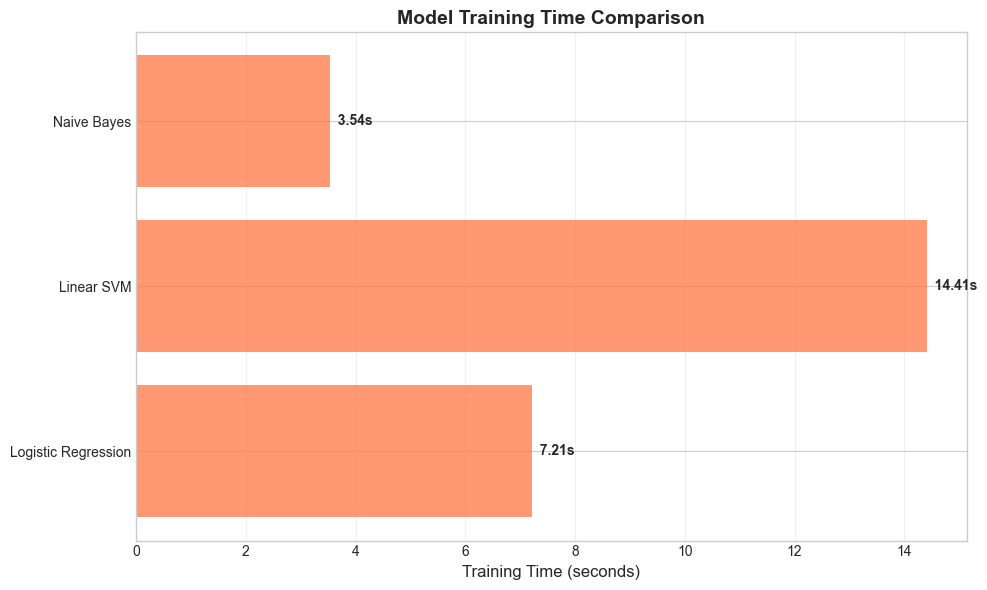

✅ Saved: training_time_comparison.png


In [31]:
# Training time comparison
plt.figure(figsize=(10, 6))
train_times = comparison_df. set_index('Model')['Training Time (s)']
bars = plt.barh(range(len(train_times)), train_times.values, color='coral', alpha=0.8)
plt.yticks(range(len(train_times)), train_times.index)
plt.xlabel('Training Time (seconds)', fontsize=12)
plt.title('Model Training Time Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (model, time_val) in enumerate(train_times.items()):
    plt.text(time_val, i, f'  {time_val:.2f}s', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: training_time_comparison.png")

Select & Evaluate Best Model on Test Set

In [32]:
# Select best model
best_model = models_results[best_model_name]['model']

print(f"\n Selected Model: {best_model_name}")
print(f"   Based on validation F1-Score: {best_model_f1*100:.2f}%")

# Evaluate on test set
print(f"\n Evaluating on test set...")
start_time = time.time()

y_test_pred = best_model.predict(X_test_tfidf)

if hasattr(best_model, 'predict_proba'):
    y_test_proba = best_model. predict_proba(X_test_tfidf)
else:
    y_test_proba = None

inference_time = time.time() - start_time
avg_inference_time = inference_time / len(X_test) * 1000  # ms per sample

print(f"✅ Inference complete in {inference_time:.2f} seconds")
print(f"   Average:  {avg_inference_time:.2f} ms per sample")


 Selected Model: Logistic Regression
   Based on validation F1-Score: 77.13%

 Evaluating on test set...
✅ Inference complete in 0.02 seconds
   Average:  0.00 ms per sample


In [35]:
# Calculate test metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"\n{'='*80}")
print(f"TEST SET PERFORMANCE - {best_model_name}")
print(f"{'='*80}")
print(f"\n Overall Metrics:")
print(f"   Accuracy:   {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"   Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"   F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")


TEST SET PERFORMANCE - Logistic Regression

 Overall Metrics:
   Accuracy:   0.7717 (77.17%)
   Precision: 0.7728 (77.28%)
   Recall:    0.7717 (77.17%)
   F1-Score:  0.7716 (77.16%)


In [39]:
# Per-class metrics
print(f"\n PER-CLASS METRICS:")
per_class_precision, per_class_recall, per_class_f1, per_class_support = \
    precision_recall_fscore_support(y_test, y_test_pred)

labels = sorted(y_test.unique())
for i, label in enumerate(labels):
    print(f"\n   {label}:")
    print(f"      Precision: {per_class_precision[i]:.4f} ({per_class_precision[i]*100:.2f}%)")
    print(f"      Recall:    {per_class_recall[i]:.4f} ({per_class_recall[i]*100:.2f}%)")
    print(f"      F1-Score:  {per_class_f1[i]:.4f} ({per_class_f1[i]*100:.2f}%)")
    print(f"      Support:   {per_class_support[i]} samples")


 PER-CLASS METRICS:

   Negative:
      Precision: 0.7911 (79.11%)
      Recall:    0.7464 (74.64%)
      F1-Score:  0.7681 (76.81%)
      Support:   111436 samples

   Positive:
      Precision: 0.7539 (75.39%)
      Recall:    0.7977 (79.77%)
      F1-Score:  0.7752 (77.52%)
      Support:   108546 samples


In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n CONFUSION MATRIX:\n")
print(cm)


 CONFUSION MATRIX:

[[83171 28265]
 [21956 86590]]


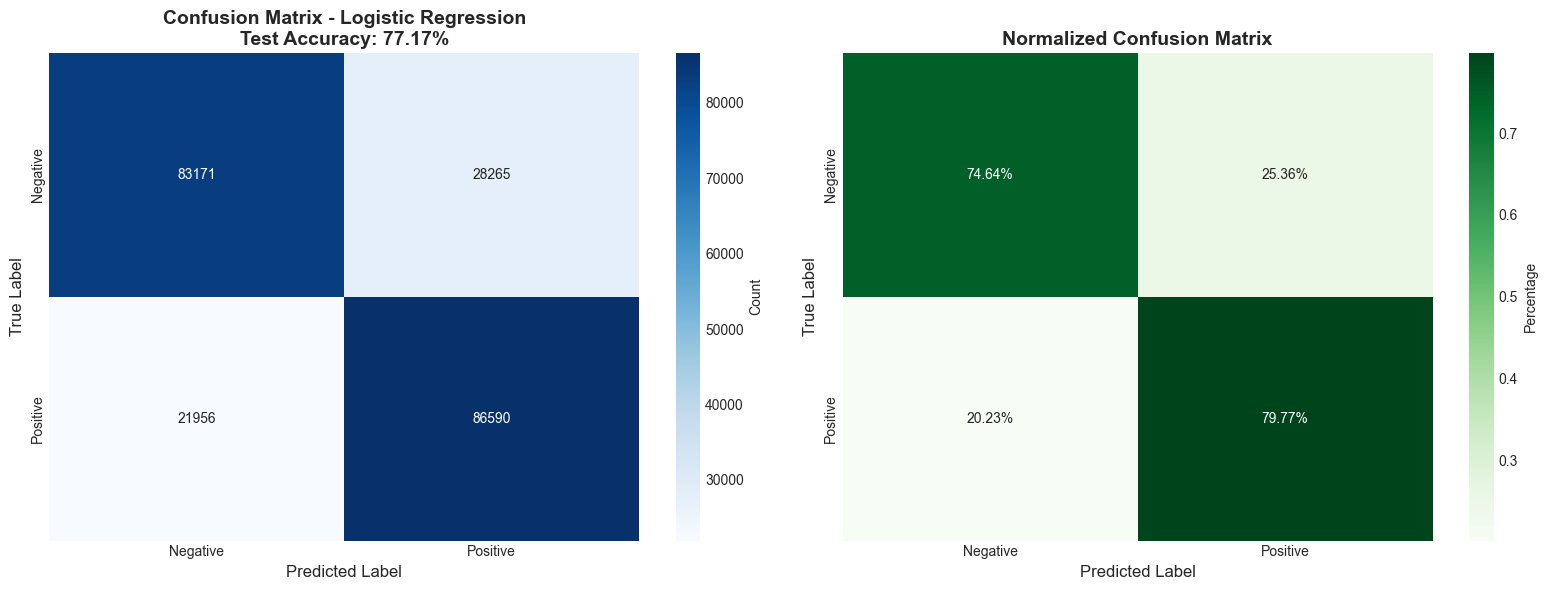


✅ Saved: final_confusion_matrix.png


In [41]:
# Visualize detailed confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {test_acc*100:.2f}%', 
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Percentage'})
axes[1].set_title(f'Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: final_confusion_matrix.png")

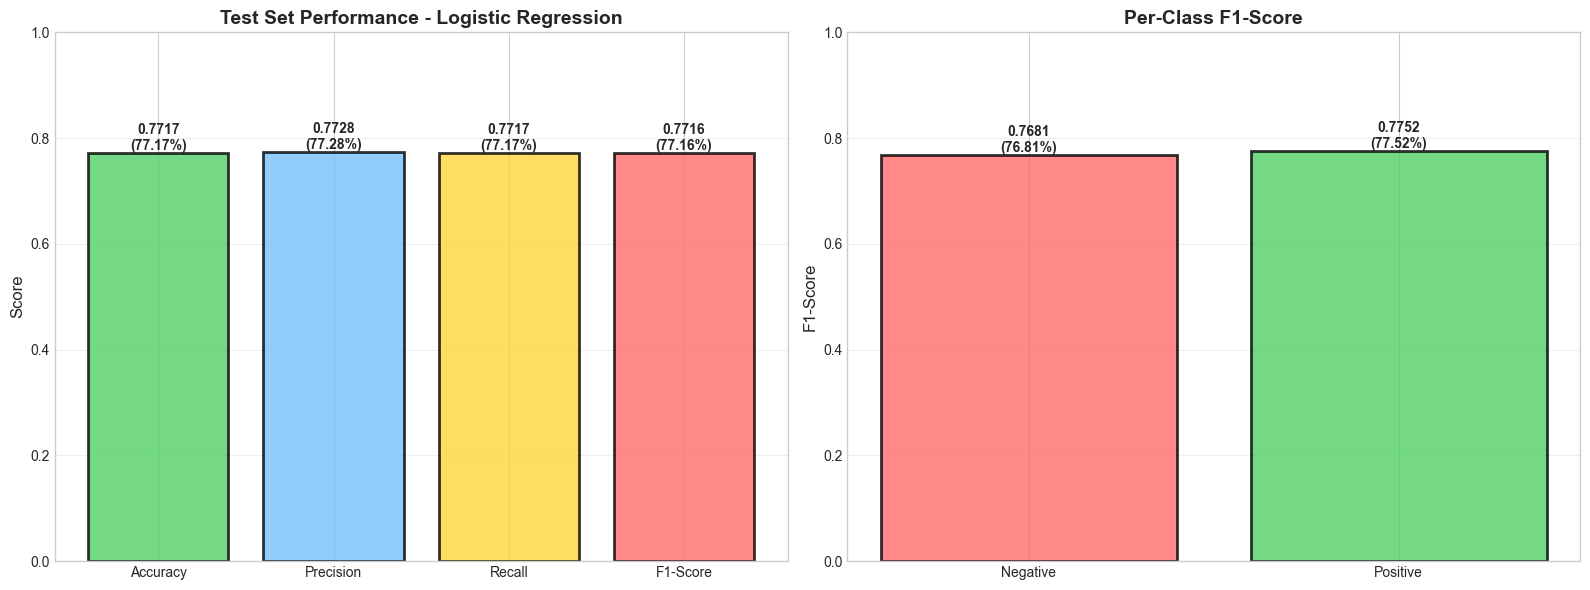

✅ Saved: test_performance_summary.png


In [42]:
# Performance summary visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [test_acc, test_precision, test_recall, test_f1]
colors_metrics = ['#51cf66', '#74c0fc', '#ffd43b', '#ff6b6b']

bars = axes[0].bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_ylim([0, 1.0])
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title(f'Test Set Performance - {best_model_name}', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}\n({val*100:.2f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# Per-class F1-Score
axes[1].bar(range(len(labels)), per_class_f1, 
           color=[{'Positive': '#51cf66', 'Negative': '#ff6b6b', 'Neutral': '#ffd43b'}. get(l, '#999') for l in labels],
           alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(labels)))
axes[1].set_xticklabels(labels, rotation=0)
axes[1].set_ylim([0, 1.0])
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Per-Class F1-Score', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

for i, (label, score) in enumerate(zip(labels, per_class_f1)):
    axes[1].text(i, score, f'{score:.4f}\n({score*100:.2f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('test_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: test_performance_summary.png")

In [44]:
# Sample predictions
print(f"\n📝 SAMPLE PREDICTIONS (10 random examples):\n")
sample_indices = np.random.choice(len(X_test), size=10, replace=False)

for idx in sample_indices: 
    text = X_test.iloc[idx]
    true_label = y_test.iloc[idx]
    pred_label = y_test_pred[idx]
    
    correct = "✅" if true_label == pred_label else "❌"
    
    print(f"{correct} Text: {text[: 80]}...")
    print(f"   True:  {true_label:12} | Predicted: {pred_label:12}")
    
    if y_test_proba is not None:
        proba_dict = dict(zip(labels, y_test_proba[idx]))
        print(f"   Confidence: {proba_dict}")
    print()



📝 SAMPLE PREDICTIONS (10 random examples):

❌ Text: seemingly talent geographically restrictive...
   True:  Negative     | Predicted: Positive    
   Confidence: {'Negative': np.float64(0.2376704177547615), 'Positive': np.float64(0.7623295822452385)}

✅ Text: hey made twitter...
   True:  Positive     | Predicted: Positive    
   Confidence: {'Negative': np.float64(0.1098630162120866), 'Positive': np.float64(0.8901369837879134)}

✅ Text: absolutely nothing alll weekend fun...
   True:  Positive     | Predicted: Positive    
   Confidence: {'Negative': np.float64(0.36348419868438775), 'Positive': np.float64(0.6365158013156123)}

✅ Text: fun day natalya ash lexus bed cuz buy lvatt new jonas album...
   True:  Positive     | Predicted: Positive    
   Confidence: {'Negative': np.float64(0.17298877575262217), 'Positive': np.float64(0.8270112242473778)}

✅ Text: thanks lot recommendations...
   True:  Positive     | Predicted: Positive    
   Confidence: {'Negative': np.float64(0.17990289

Save Models

In [45]:
# Create models directory if it doesn't exist
import os
print(f"\n Saving best model...")
model_filename = '/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/sentiment_model. pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"   ✅ Saved: {model_filename}")


 Saving best model...
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/sentiment_model. pkl


In [46]:
# Save TF-IDF vectorizer
print(f"\n Saving TF-IDF vectorizer...")
vectorizer_filename = '/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/tfidf_vectorizer.pkl'

with open(vectorizer_filename, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print(f"   ✅ Saved: {vectorizer_filename}")


 Saving TF-IDF vectorizer...
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/tfidf_vectorizer.pkl


In [47]:
# Save model metadata
print(f"\n Saving model metadata...")

model_info = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Performance metrics
    'test_accuracy': float(test_acc),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    
    # Per-class metrics
    'per_class_metrics': {
        label: {
            'precision': float(per_class_precision[i]),
            'recall': float(per_class_recall[i]),
            'f1':  float(per_class_f1[i]),
            'support': int(per_class_support[i])
        }
        for i, label in enumerate(labels)
    },
    
    # Dataset info
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples':  len(X_test),
    'total_samples': len(df),
    
    # Feature info
    'vocabulary_size': len(tfidf_vectorizer. vocabulary_),
    'max_features':  tfidf_config['max_features'],
    'ngram_range': tfidf_config['ngram_range'],
    
    # Training info
    'training_time': float(models_results[best_model_name]['train_time']),
    'inference_time_ms': float(avg_inference_time),
    
    # Model parameters
    'model_params': best_model.get_params(),
    
    # Class labels
    'class_labels': labels
}

metadata_filename = '/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/model_info.json'
with open(metadata_filename, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"   ✅ Saved: {metadata_filename}")


 Saving model metadata...
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/model_info.json


In [48]:
#Save all models (for comparison)
print(f"\n Saving all trained models...")

for model_name, results in models_results.items():
    safe_name = model_name.replace(' ', '_').lower()
    filename = f'/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/{safe_name}_model.pkl'
    

    if os.path.exists(filename):
        print(f"   ⚠️ Model already exists: {filename}. Overwriting...")
    
    with open(filename, 'wb') as f:
        pickle.dump(results['model'], f)
    
    print(f"   ✅ Saved: {filename}")


 Saving all trained models...
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/logistic_regression_model.pkl
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/naive_bayes_model.pkl
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/linear_svm_model.pkl


In [49]:
## Save training history
print(f"\n Saving training history...")

training_history = {
    'models': {
        model_name: {
            'accuracy': float(results['accuracy']),
            'precision': float(results['precision']),
            'recall': float(results['recall']),
            'f1': float(results['f1']),
            'train_time':  float(results['train_time'])
        }
        for model_name, results in models_results. items()
    },
    'best_model': best_model_name,
    'best_f1_score': float(best_model_f1)
}

history_filename = '/home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/training_history.json'
with open(history_filename, 'w') as f:
    json.dump(training_history, f, indent=2)

print(f"   ✅ Saved: {history_filename}")


 Saving training history...
   ✅ Saved: /home/len/Downloads/iaIot/m3/sentiment_analysis_nlp/models/training_history.json


In [52]:
"""
================================================================================
CELL 8: TRAINING SUMMARY & RESULTS
================================================================================
Final summary of the entire training process
"""

print("="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)

print(f"""
 PROJECT SUMMARY:  

{'='*80}
1. DATASET INFORMATION
{'='*80}

   Total Samples:       {len(df):,}
   Training Set:       {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)
   Validation Set:     {len(X_val):,} ({len(X_val)/len(df)*100:.1f}%)
   Test Set:           {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)
   
   Sentiment Classes:  {', '.join(labels)}

{'='*80}
2. FEATURE EXTRACTION
{'='*80}

   Method:             TF-IDF Vectorization
   Vocabulary Size:     {len(tfidf_vectorizer.vocabulary_):,} terms
   Max Features:       {tfidf_config['max_features']: ,}
   N-gram Range:       {tfidf_config['ngram_range']}
   Matrix Sparsity:    {sparsity:.2f}%

{'='*80}
3. MODELS TRAINED
{'='*80}
""")

for model_name, results in sorted(models_results.items(), key=lambda x: x[1]['f1'], reverse=True):
    print(f"\n   {model_name}:")
    print(f"      Validation Accuracy:   {results['accuracy']*100:.2f}%")
    print(f"      Validation F1-Score:   {results['f1']*100:.2f}%")
    print(f"      Training Time:        {results['train_time']:.2f}s")

print(f"""
{'='*80}
4. BEST MODEL PERFORMANCE
{'='*80}

   Selected Model:     {best_model_name}
   Selection Criteria:  Highest Validation F1-Score
   
    TEST SET RESULTS:
   
   Accuracy:           {test_acc:.4f} ({test_acc*100:.2f}%)
   Precision:          {test_precision:.4f} ({test_precision*100:.2f}%)
   Recall:             {test_recall:.4f} ({test_recall*100:.2f}%)
   F1-Score:           {test_f1:.4f} ({test_f1*100:.2f}%)
   
   Inference Speed:    {avg_inference_time:.2f} ms per sample

{'='*80}
5. PER-CLASS PERFORMANCE
{'='*80}
""")

for i, label in enumerate(labels):
    print(f"\n   {label}:")
    print(f"      Precision: {per_class_precision[i]*100:.2f}%")
    print(f"      Recall:    {per_class_recall[i]*100:.2f}%")
    print(f"      F1-Score:  {per_class_f1[i]*100:.2f}%")
    print(f"      Samples:   {per_class_support[i]: ,}")

print(f"""
{'='*80}
6. FILES GENERATED
{'='*80}

   ✅ Models: 
      • sentiment_model.pkl
      • tfidf_vectorizer.pkl
      • model_info.json
      • training_history.json
      • All individual models saved
   
   ✅ Visualizations:
      • data_split_distribution.png
      • top_tfidf_features.png
      • model_comparison.png
      • confusion_matrices_comparison.png
      • training_time_comparison.png
      • final_confusion_matrix.png
      • test_performance_summary.png

{'='*80}
7. MODEL DEPLOYMENT READINESS
{'='*80}

   ✅ Model trained and validated
   ✅ Test performance verified
   ✅ Model and vectorizer saved
   ✅ Metadata documented
   ✅ Ready for Streamlit deployment

{'='*80}
8. NEXT STEPS
{'='*80}

   1. Build Streamlit Web Application
      • Load saved model and vectorizer
      • Create user interface
      • Add prediction functionality
      • Test locally
   
   2. Deploy to Cloud
      • Push to GitHub
      • Deploy on Streamlit Cloud
      • Test live application
   
   3. Documentation
      • Write README. md
      • Create user guide
      • Prepare presentation
   
   4. Submit Project
      • Code + Models
      • Documentation
      • Live demo link
      • Presentation slides

{'='*80}
 TRAINING PHASE COMPLETED SUCCESSFULLY!
{'='*80}

Ready for deployment phase!  🚀

Next notebook: Build Streamlit Application
Estimated time: 1-2 hours

""")

# Create final results DataFrame for documentation
final_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [test_acc, test_precision, test_recall, test_f1],
    'Percentage': [f'{test_acc*100:.2f}%', f'{test_precision*100:.2f}%', 
                  f'{test_recall*100:.2f}%', f'{test_f1*100:.2f}%']
})

print(f"\n FINAL RESULTS TABLE:\n")
display(final_results)

print(f"\n{'='*80}")
print(f"✅ ALL TRAINING TASKS COMPLETED!")
print(f"{'='*80}")

TRAINING COMPLETE - FINAL SUMMARY

 PROJECT SUMMARY:  

1. DATASET INFORMATION

   Total Samples:       1,466,544
   Training Set:       1,027,167 (70.0%)
   Validation Set:     219,395 (15.0%)
   Test Set:           219,982 (15.0%)

   Sentiment Classes:  Negative, Positive

2. FEATURE EXTRACTION

   Method:             TF-IDF Vectorization
   Vocabulary Size:     5,000 terms
   Max Features:        5,000
   N-gram Range:       (1, 2)
   Matrix Sparsity:    99.88%

3. MODELS TRAINED


   Logistic Regression:
      Validation Accuracy:   77.14%
      Validation F1-Score:   77.13%
      Training Time:        7.21s

   Linear SVM:
      Validation Accuracy:   77.09%
      Validation F1-Score:   77.08%
      Training Time:        14.41s

   Naive Bayes:
      Validation Accuracy:   75.46%
      Validation F1-Score:   75.45%
      Training Time:        3.54s

4. BEST MODEL PERFORMANCE

   Selected Model:     Logistic Regression
   Selection Criteria:  Highest Validation F1-Score

    TEST 

,Metric,Score,Percentage
0,Accuracy,0.771704,77.17%
1,Precision,0.772772,77.28%
2,Recall,0.771704,77.17%
3,F1-Score,0.771602,77.16%



✅ ALL TRAINING TASKS COMPLETED!
